In [33]:
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [34]:
import os

os.environ["TF_GPU_THREAD_MODE"] = "gpu_private"

import tensorflow as tf
from tensorflow import keras
import tensorflow_addons as tfa 
import numpy as np
import matplotlib.pyplot as plt
import datetime

tf.config.optimizer.set_jit(True)

In [35]:
[
    (train_features, train_labels),
    (test_features, test_labels),
] = keras.datasets.cifar10.load_data()

train_features = train_features / 255.0
test_features = test_features / 255.0

In [36]:
BATCH_SIZE = 512
IMAGE_SIZE = 32

In [37]:
class Augmentation(keras.layers.Layer):
  def __init__(self):
    super(Augmentation, self).__init__()

  @tf.function
  def random_execute(self, prob: float):
    return tf.random.uniform([], minval=0, maxval=1) < prob

In [38]:
class RandomToGrayscale(Augmentation):
  @tf.function
  def call(self, x: tf.Tensor):
    if self.random_execute(0.2):
      x = tf.image.rgb_to_grayscale(x)
      x = tf.tile(x, [1, 1, 3])
    return x

In [39]:
class RandomColorJitter(Augmentation):
  @tf.function
  def call(self, x: tf.Tensor):
    if self.random_execute(0.8):
      x = tf.image.random_brightness(x, 0.8)
      x = tf.image.random_contrast(x, 0.4, 1.6)
      x = tf.image.random_saturation(x, 0.4, 1.6)
      x = tf.image.random_hue(x, 0.2)
    
    return x

In [40]:
class RandomFlip(Augmentation):
  @tf.function
  def call(self, x: tf.Tensor):
    if self.random_execute(0.5):
      x = tf.image.random_flip_left_right(x)

    return x

In [41]:
class RandomResizedCrop(Augmentation):
  def __init__(self, image_size):
    super(Augmentation, self).__init__()
    self.image_size = image_size

  def call(self, x: tf.Tensor):
    rand_size = tf.random.uniform(
        shape=[],
        minval=int(0.75 * self.image_size),
        maxval=1 * self.image_size,
        dtype=tf.int32,
    )

    crop = tf.image.random_crop(x, (rand_size, rand_size, 3))
    crop_resize = tf.image.resize(crop, (self.image_size, self.image_size))
    return crop_resize

In [42]:
class RandomSolarize(Augmentation):
  @tf.function
  def call(self, x: tf.Tensor):
    if self.random_execute(0.2):
      x = tf.where(x < 10, x, 255 - x)
    
    return x

In [43]:
class RandomBlur(Augmentation):
  @tf.function
  def call(self, x: tf.Tensor):
    if self.random_execute(0.2):
      s = np.random.random()
      return tfa.image.gaussian_filter2d(image=x, sigma=s)
    return x

In [44]:
class RandomAugmentor(keras.Model):
  def __init__(self, image_size: int):
    super(RandomAugmentor, self).__init__()

    self.image_size = image_size
    self.random_resized_crop = RandomResizedCrop(image_size)
    self.random_flip = RandomFlip()
    self.random_color_jitter = RandomColorJitter()
    self.random_blur = RandomBlur()
    self.random_to_grayscale = RandomToGrayscale()
    self.random_solarize = RandomSolarize()

  def call(self, x: tf.Tensor):
    x = self.random_resized_crop(x)
    x = self.random_flip(x)
    x = self.random_color_jitter(x)
    x = self.random_blur(x)
    x = self.random_to_grayscale(x)
    x = self.random_solarize(x)

    x = tf.clip_by_value(x, 0, 1)
    return x

bt_augmentor = RandomAugmentor(IMAGE_SIZE)

In [45]:
class BTDatasetCreator:
  def __init__(self, augmentor: RandomAugmentor, seed: int = 1024):
    self.options = tf.data.Options()
    self.options.threading.max_intra_op_parallelism = 1
    self.seed = seed
    self.augmentor = augmentor


  def augmented_version(self, ds: list):
    return (
        tf.data.Dataset.from_tensor_slices(ds)
        .shuffle(1000, seed=self.seed)
        .map(self.augmentor, num_parallel_calls=tf.data.AUTOTUNE)
        .batch(BATCH_SIZE, drop_remainder=True)
        .prefetch(tf.data.AUTOTUNE)
        .with_options(self.options))

  def __call__(self, ds: list):
    a1 = self.augmented_version(ds)
    a2 = self.augmented_version(ds)

    return tf.data.Dataset.zip((a1, a2)).with_options(self.options)

augment_versions = BTDatasetCreator(bt_augmentor)(train_features)

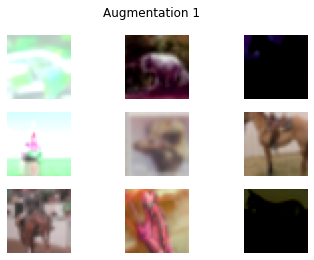

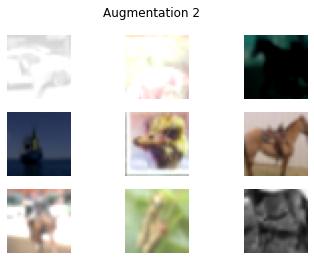

In [46]:
sample_augment_versions = iter(augment_versions)

def plot_values(batch: tuple):
  fig, ax = plt.subplots(3, 3)
  fig1, ax1 = plt.subplots(3, 3)

  fig.suptitle("Augmentation 1")
  fig1.suptitle("Augmentation 2")

  a1, a2 = batch

  for i in range(3):
    for j in range(3):
      ax[i][j].imshow(a1[3 * i + j])
      ax[i][j].axis("off")
      ax1[i][j].imshow(a2[3 * i + j])
      ax1[i][j].axis("off")

  plt.show()


plot_values(next(sample_augment_versions))

In [46]:
class BarlowLoss(keras.losses.Loss):
  def __init__(self, batch_size: int):
    super(BarlowLoss, self).__init__()
    self.lambda_amt = 5e-3
    self.batch_size = batch_size
  
  def get_off_diag(self, c: tf.Tensor):
    zero_diag = tf.zeros(c.shape[-1])
    return tf.linalg.set_diag(c, zero_diag)

  def cross_corr_matrix_loss(self, c: tf.Tensor):
    c_diff = tf.pow(tf.linalg.diag_part(c) - 1, 2)
    off_diag = tf.pow(self.get_off_diag(c), 2)
    loss = tf.reduce_sum(c_diff) + tf.reduce_sum(off_diag)

    return loss